# Проектная работа: рынок заведений общественного питания Москвы

**Контекст:** инвесторы из фонда «Shut Up and Take My Money» решили попробовать себя в новой области и открыть заведение общественного питания в Москве. Заказчики ещё не знают, что это будет за место: кафе, ресторан, пиццерия, паб или бар, — и какими будут расположение, меню и цены.
Поставлена задача — подготовить исследование рынка Москвы, найти интересные особенности и презентовать полученные результаты, которые в будущем помогут в выборе подходящего инвесторам места.

## Загрузка данных и изучение общей информации

In [1]:
import re
import json
import folium
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
from folium import Map, Choropleth, Marker

In [2]:
df = pd.read_csv('D:\\ds\\moscow_places.csv')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 200)

In [3]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def prep(dataframe):
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    return dataframe

def get_info(dataframe):
    display(dataframe.head(5))
    print('*'*50)
    dataframe.info()
    print('*'*50)
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print('*'*39)
    print('Пропусков в колонках:')
    missing_counts = dataframe.isna().sum()
    percentage_missing = (missing_counts / dataframe.shape[0]) * 100
    print(pd.concat([missing_counts, percentage_missing.round(1)], axis=1, keys=['Количество', 'Доля, %']))

In [4]:
df = prep(df)
get_info(df)

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00–02:00",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB
**********

Проверка показывает:
- 536 (6,4%) пропущенных значений в столбце с данными о времени работы заведения. Восстановить возможно, но нецелесообразно. 
- 3611 (43%) пропусков в данных о количестве посадочных мест. Восстановление такого объёма пропущенных значений слишком трудозатратно и также нецелесообразно.
- 7871 (93.6%) пропусков в данных о средней стоимости кружки кофе. Основная характеристика для кофеен и незначительная для всех прочих категорий заведений. Так как это стоимость конкретной отдельной позиции, пытаться восстановить это значение, исходя из суммы среднего чека, будет всё же не совсем корректно, так что придётся оставить эти пропуски как есть.
- 54-62% пропусков в данных о среднем чеке. Три колонки с данными перекликаются между собой, постараюсь восстановить значения, используя взаимосвязи в таблице.

## Предобработка

### Поиск неявных дубликатов

Отформатирую в нижний регистр названия заведений и поищу дубликаты.

In [5]:
df['name'] = df['name'].str.lower()
df[df.duplicated(subset=['name', 'address'], keep=False)]

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
1430,more poke,ресторан,"Москва, Волоколамское шоссе, 11, стр. 2",Северный административный округ,"ежедневно, 09:00–21:00",55.806307,37.497566,4.2,NaN,NaN,NaN,NaN,0,188.0
1511,more poke,ресторан,"Москва, Волоколамское шоссе, 11, стр. 2",Северный административный округ,"пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00–18:00",55.806307,37.497566,4.2,NaN,NaN,NaN,NaN,1,188.0
2211,раковарня клешни и хвосты,ресторан,"Москва, проспект Мира, 118",Северо-Восточный административный округ,"ежедневно, 12:00–00:00",55.810553,37.638161,4.4,NaN,NaN,NaN,NaN,0,150.0
2420,раковарня клешни и хвосты,"бар,паб","Москва, проспект Мира, 118",Северо-Восточный административный округ,"пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00–00:00",55.810677,37.638379,4.4,NaN,NaN,NaN,NaN,1,150.0
3091,хлеб да выпечка,булочная,"Москва, Ярцевская улица, 19",Западный административный округ,"ежедневно, 09:00–22:00",55.738886,37.411648,4.1,NaN,NaN,NaN,NaN,1,276.0
3109,хлеб да выпечка,кафе,"Москва, Ярцевская улица, 19",Западный административный округ,NaN,55.738449,37.410937,4.1,NaN,NaN,NaN,NaN,0,276.0


In [6]:
df.drop([1430, 2211, 3109], inplace=True)

### Восстановление пропусков

Извлеку из столбца avg_bill, где содержится описание среднего чека в виде строки, числа и посчитаю на их основе значение для столбца middle_avg_bill.

In [7]:
replacements = []
def extract_number(text):
    if pd.isna(text):
        return None
    matches = re.findall(r'\d+', text)
    if matches:
        numbers = list(map(int, matches))
        if len(numbers) == 2:
            number = sum(numbers) / 2
        else:
            number = numbers[0]
        replacements.append(number)
        return number
    return None

In [8]:
df['middle_avg_bill'] = (
    df.apply(
        lambda row: extract_number(row['avg_bill']) 
            if pd.isna(row['middle_avg_bill']) 
            else row['middle_avg_bill'], axis=1))

Далее, где возможно, попробую заполнить категории в столбце price. Чтоб понять как они расставлены посмотрю на описание данных.

In [9]:
df_low = df.query('price == "низкие"')
df_low['middle_avg_bill'].describe()

count    150.000000
mean     186.653333
std      101.202650
min       60.000000
25%      134.250000
50%      150.000000
75%      200.000000
max      600.000000
Name: middle_avg_bill, dtype: float64

In [10]:
df_mid = df.query('price == "средние"')
df_mid['middle_avg_bill'].describe()

count    1944.000000
mean      545.335391
std       305.747411
min        60.000000
25%       300.000000
50%       450.000000
75%       750.000000
max      2150.000000
Name: middle_avg_bill, dtype: float64

In [11]:
df_upmid = df.query('price == "выше среднего"')
df_upmid['middle_avg_bill'].describe()

count     524.000000
mean     1260.994275
std       354.254764
min       150.000000
25%      1250.000000
50%      1250.000000
75%      1500.000000
max      4500.000000
Name: middle_avg_bill, dtype: float64

In [12]:
df_high = df.query('price == "высокие"')
df_high['middle_avg_bill'].describe()

count      455.000000
mean      2388.948352
std       1878.676322
min          0.000000
25%       1750.000000
50%       2000.000000
75%       2500.000000
max      35000.000000
Name: middle_avg_bill, dtype: float64

Логика деления на категории не такая очевидная, как хотелось бы. Некоторые суммы присутствуют сразу в нескольких категориях. А в "высоких" наблюдается значение среднего чека 0 - явная ошибка. Посмотрю много ли таких аномальных значений и попробую как-то расставить категории для восстановления пропусков на своё усмотрение.

In [13]:
df_high.query('middle_avg_bill < 100')

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
3688,кофемания,кофейня,"Москва, улица Новый Арбат, 19",Центральный административный округ,"ежедневно, круглосуточно",55.752136,37.587784,4.5,высокие,Средний счёт:от 0 ₽,0.0,NaN,1,200.0


Пока поставлю сюда NaN.

In [14]:
df.loc[3688, 'middle_avg_bill'] = np.nan

Теперь категории.

In [15]:
def replace_price(row):
    if pd.isna(row['price']):
        if row['middle_avg_bill'] < 300:
            return 'низкие'
        elif 300 <= row['middle_avg_bill'] < 1000:
            return 'средние'
        elif 1000 <= row['middle_avg_bill'] < 1750:
            return 'выше среднего'
        elif row['middle_avg_bill'] >= 1750:
            return 'высокие'
    return row['price']

In [16]:
df['price'] = df.apply(replace_price, axis=1)

Последнее, что можно сделать - сгруппировать по названиям и извлечь из соответствующих столбцов данные, заменив ими пропуски. У заведений одной сети показатели среднего чека должны быть общими.

In [17]:
def fill_missing_values(group):
    for col in ['price', 'avg_bill', 'middle_avg_bill', 'middle_coffee_cup']:
        if group[col].isna().any():
            group[col].fillna(method='ffill', inplace=True)
            group[col].fillna(method='bfill', inplace=True)
    return group

In [18]:
df = df.groupby('name').apply(fill_missing_values)

Посмотрим, что удалось сделать.

In [19]:
missing_counts = df.isna().sum()
percentage_missing = (missing_counts / df.shape[0]) * 100
print(pd.concat([missing_counts, percentage_missing.round(1)], axis=1, keys=['Количество', 'Доля, %']))

                   Количество  Доля, %
name                        0      0.0
category                    0      0.0
address                     0      0.0
district                    0      0.0
hours                     535      6.4
lat                         0      0.0
lng                         0      0.0
rating                      0      0.0
price                    3132     37.3
avg_bill                 3341     39.8
middle_avg_bill          3341     39.8
middle_coffee_cup        7543     89.8
chain                       0      0.0
seats                    3611     43.0


Удалось сократить примерно на 20% пропуски в среднем чеке и даже почти на 4% в стоимости кружки кофе.

### Создание дополнительных столбцов

Нужно извлечь название улицы из адреса. Улицей будет всё, что идёт после слова Москва и разделителя в виде запятой, начинается либо с цифр либо с букв и продолжается до следующего разделителя в виде запятой. Также нужно учесть, что следующего разделителя может и не быть и названием улицы адрес может заканчиваться.

In [20]:
def extract_street(address):
    match = re.search(r'Москва,\s*(.*?)(?:,|\s\d|$)', address)
    return match.group(1).strip() if match else ''

In [21]:
df['street'] = df['address'].apply(extract_street)

Теперь нужно выделить круглосуточные заведения. Извлекаю информацию из столбца с часами работы, ставлю True, если заведение работает 24x7.

In [22]:
df['is_24_7'] = df['hours'].apply(lambda x: True if isinstance(x, str) and 'ежедневно, круглосуточно' in x else False)

## Исследовательский анализ данных

### Категории типа заведений

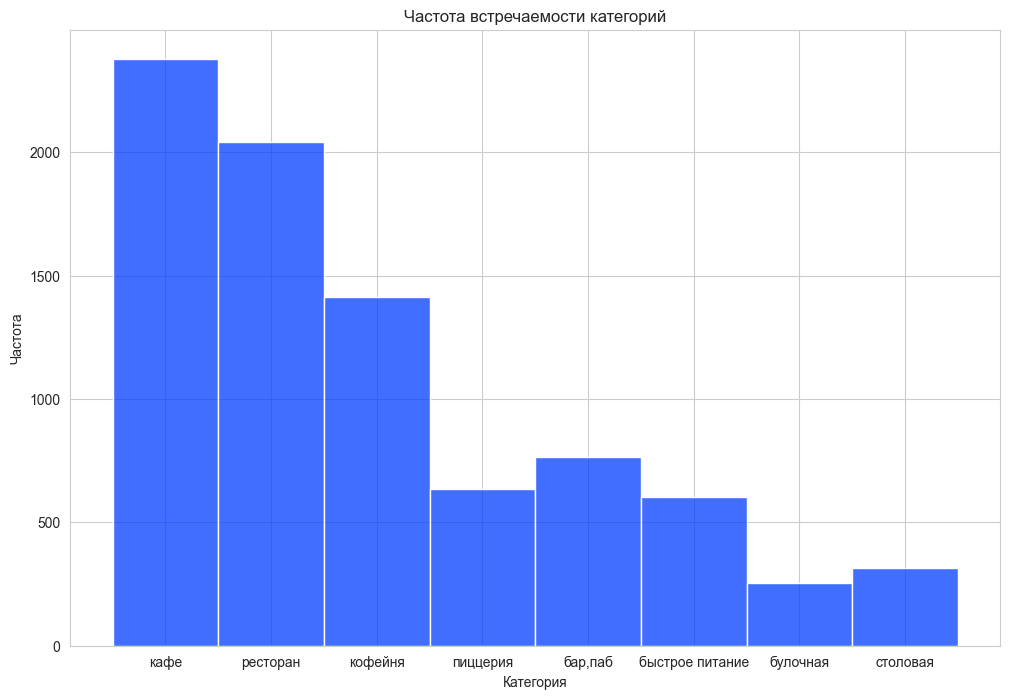

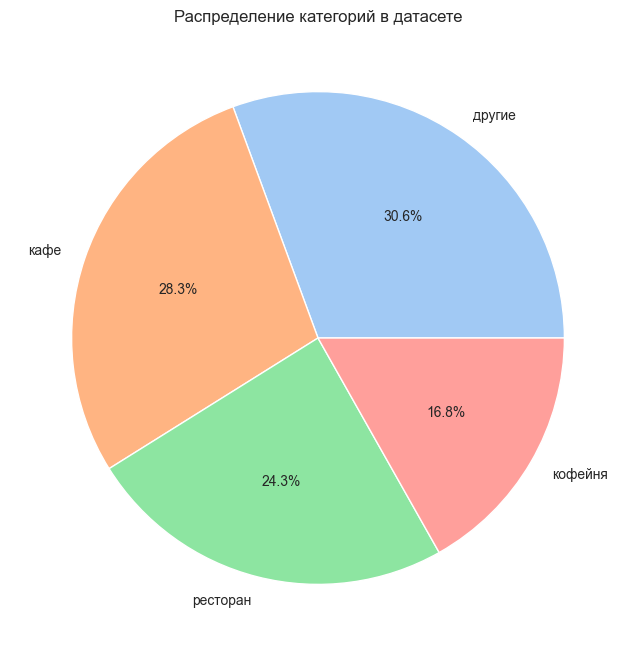

кафе               2377
ресторан           2041
кофейня            1413
бар,паб             765
пиццерия            633
быстрое питание     603
столовая            315
булочная            256
Name: category, dtype: int64

In [23]:
sns.set_style("whitegrid")
sns.set_palette("bright")
plt.figure(figsize=(12, 8))
sns.histplot(df['category'], discrete=True)
plt.title('Частота встречаемости категорий')
plt.xlabel('Категория')
plt.ylabel('Частота')

category_counts = df['category'].value_counts()
threshold = 1000
new_category_counts = {}
other_count = 0
for category, count in category_counts.items():
    if count < threshold:
        other_count += count
    else:
        new_category_counts[category] = count
if other_count > 0:
    new_category_counts['другие'] = other_count
category_counts = pd.Series(new_category_counts).sort_values(ascending=False)
plt.figure(figsize=(8, 8))
category_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Распределение категорий в датасете')
plt.ylabel('')
plt.show()

df['category'].value_counts()

Большая часть заведений представлена:
1. Кафе 2378 (28,3%)
2. Ресторан 2043 (24,3%)
3. Кофейня 1413 (16,8%)

На долю всех остальных типов заведений приходится 30,6% <br>
Реже всего встречаются булочные и столовые.

### Количество посадочных мест

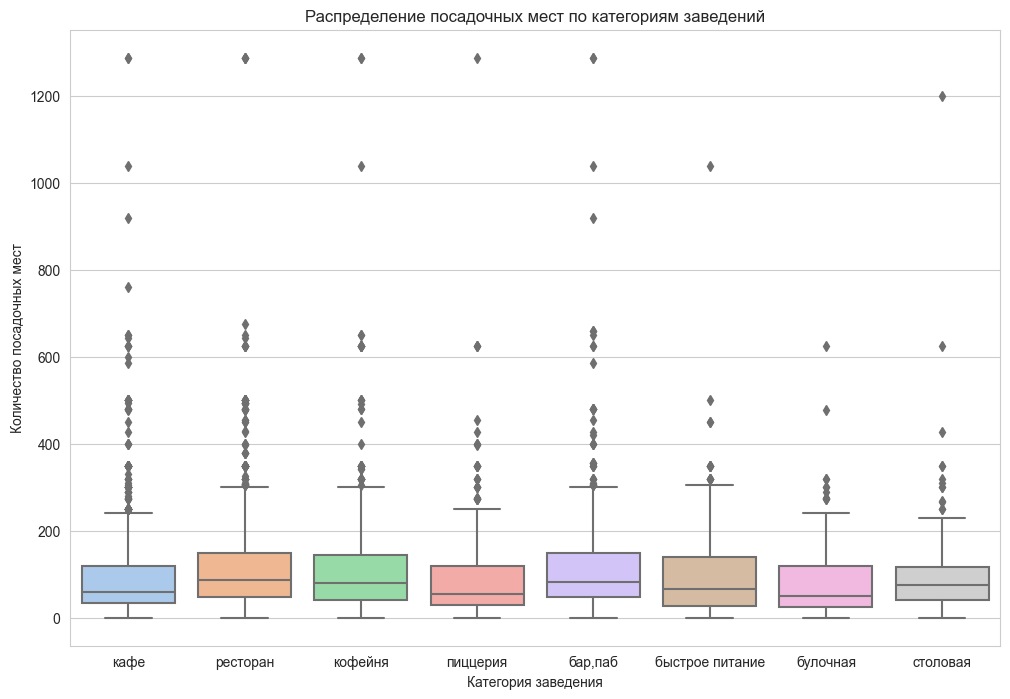

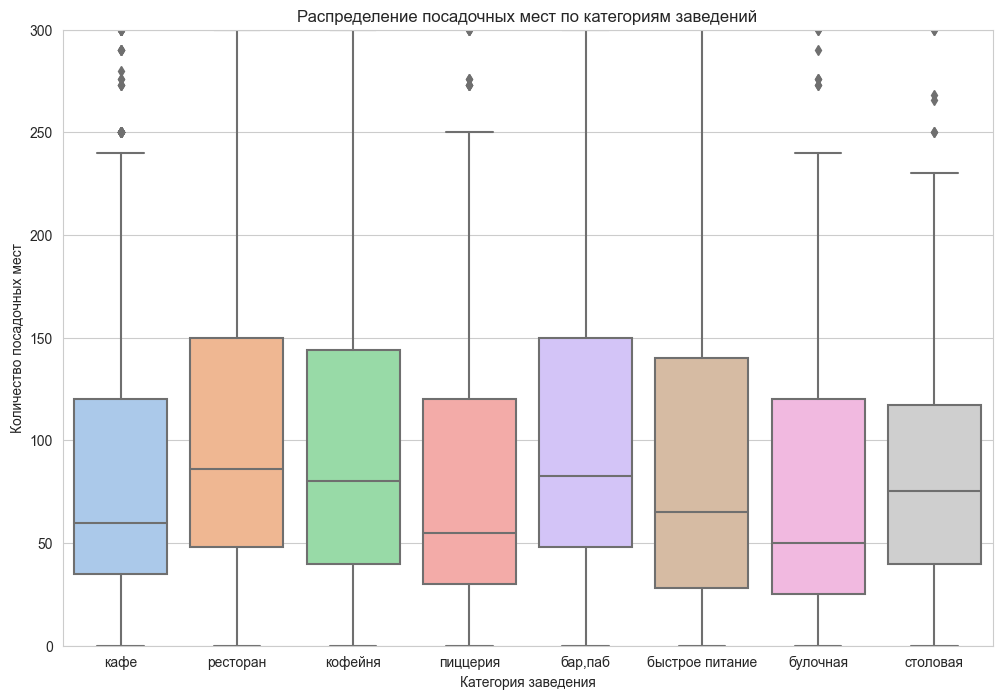

In [24]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='category', y='seats', palette='pastel')
plt.title('Распределение посадочных мест по категориям заведений')
plt.xlabel('Категория заведения')
plt.ylabel('Количество посадочных мест')

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='category', y='seats', palette='pastel')
plt.ylim(0, 300)
plt.title('Распределение посадочных мест по категориям заведений')
plt.xlabel('Категория заведения')
plt.ylabel('Количество посадочных мест')

plt.show()

На визуализации представлен один и тот же график в разном масштабе. На верхнем графике можно оценить разброс значений количества посадочных мест в разрезе по категориям. Количество выбросов довольно большое во всех категориях, что говорит о разнообразии заведений по количеству посадочных мест. Количество более 300 является сравнительно редким и выдающимся значением, но заведение, где посадочных мест будет более 1000 можно найти в любой категории, кроме булочных.<br><br>
На нижнем графике можно оценить наиболее типичные значения для категорий. Как видно, чаще всего количество посадочных мест для всех заведений составляет 40 - 150. Среднее значение для всех категорий колеблется в пределах - 50-70 мест.<br><br>
Можно углубиться ещё дальше и посмотреть на распределение количества мест внутри каждой категории поближе.

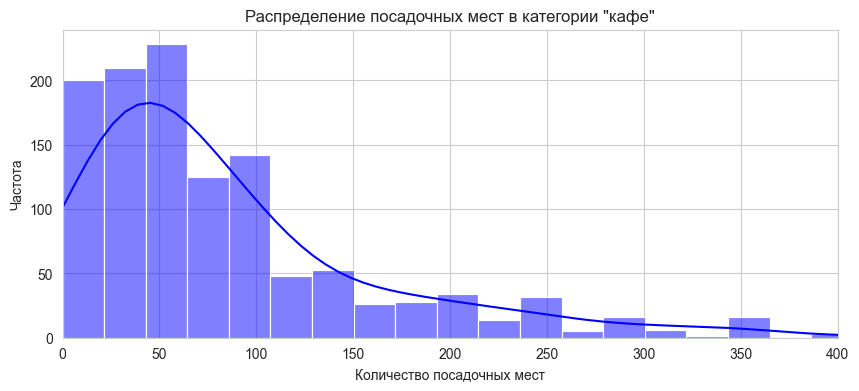

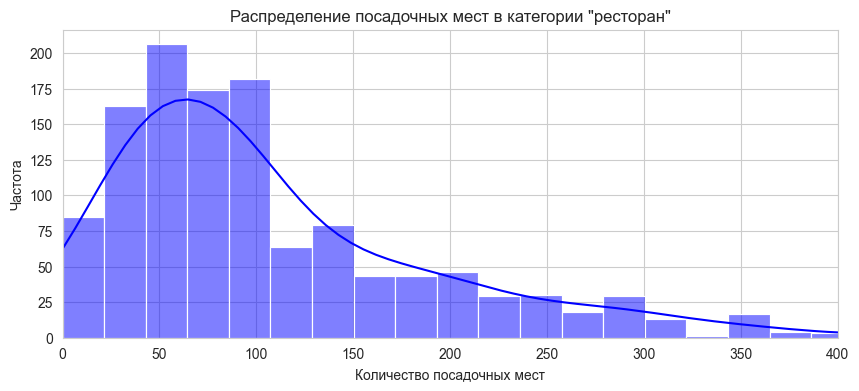

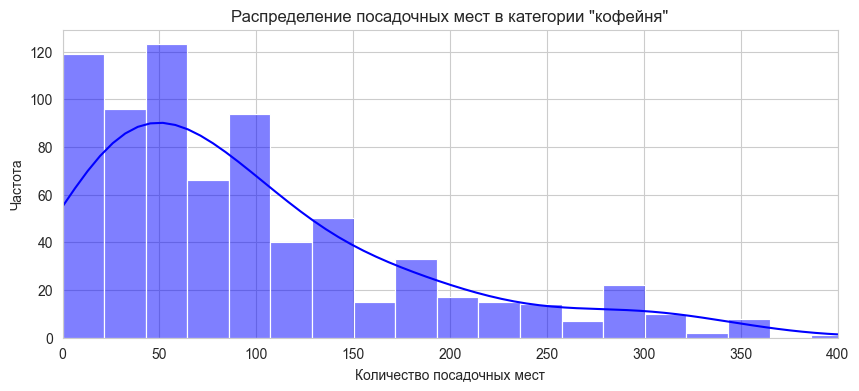

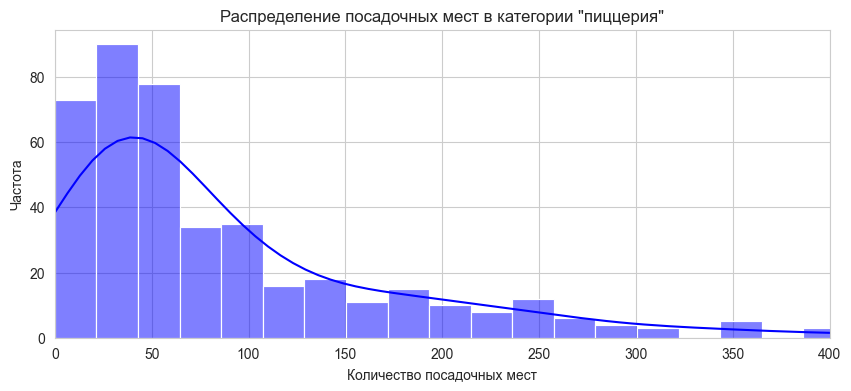

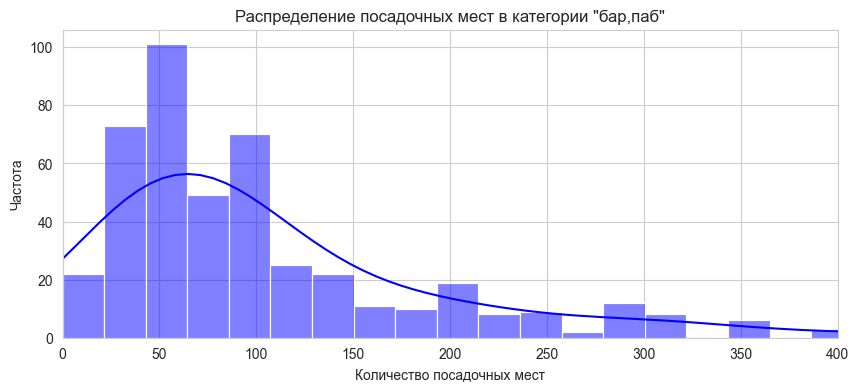

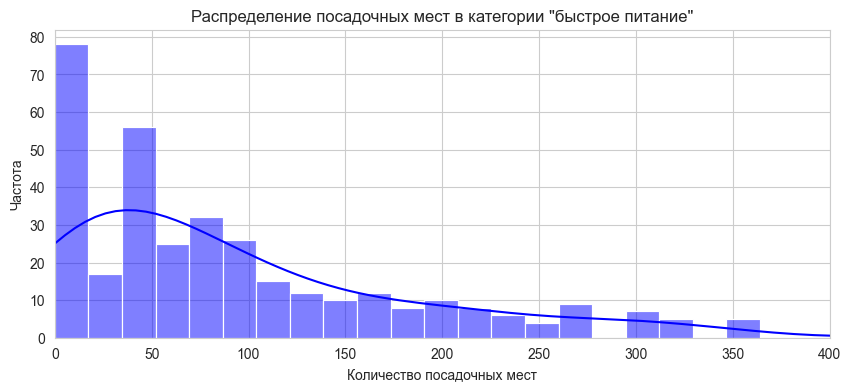

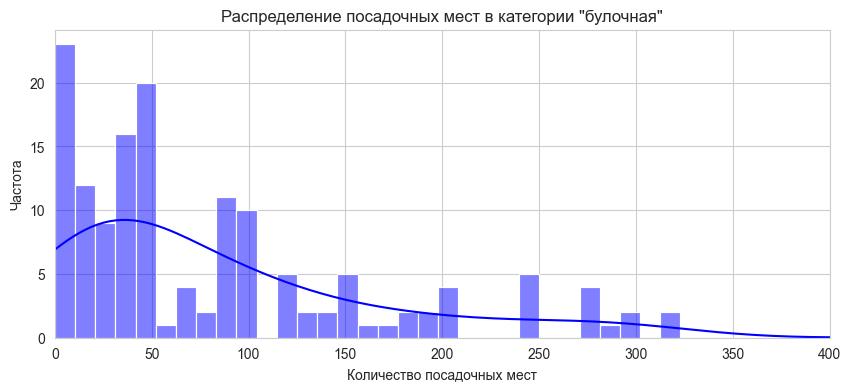

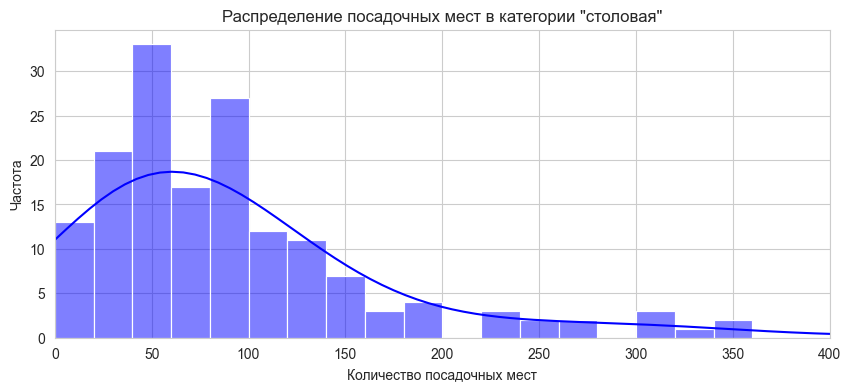

In [25]:
categories = df['category'].unique()
for category in categories:
    category_data = df[df['category'] == category] 
    plt.figure(figsize=(10, 4))
    sns.histplot(data=category_data, x='seats', bins=60, kde=True, color='blue')
    plt.xlim(0, 400)
    plt.title(f'Распределение посадочных мест в категории "{category}"')
    plt.xlabel('Количество посадочных мест')
    plt.ylabel('Частота')
    plt.show()

На таких графиках можно увидеть, какое именно количество мест характерно для каждой категории. Так, например, можно понять, что в заведениях быстрого питания скорее будет 0-15 или 35-50 посадочных мест и реже бывает 15-35 мест.

### Cоотношение сетевых и несетевых заведений

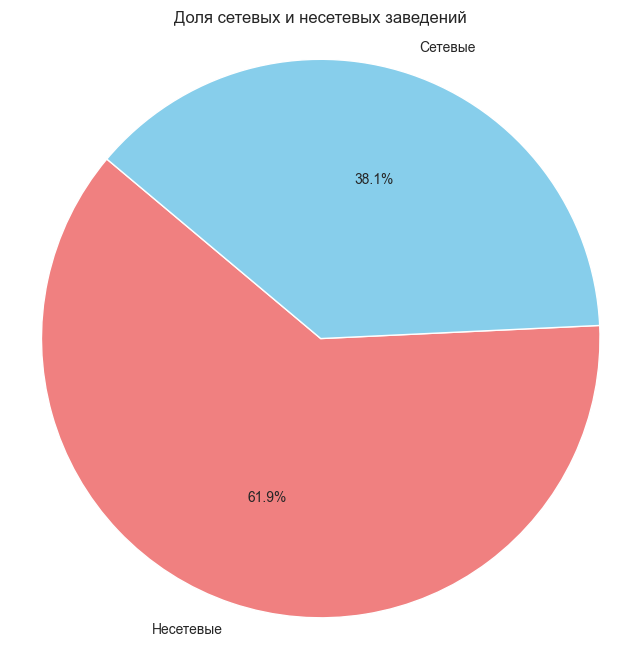

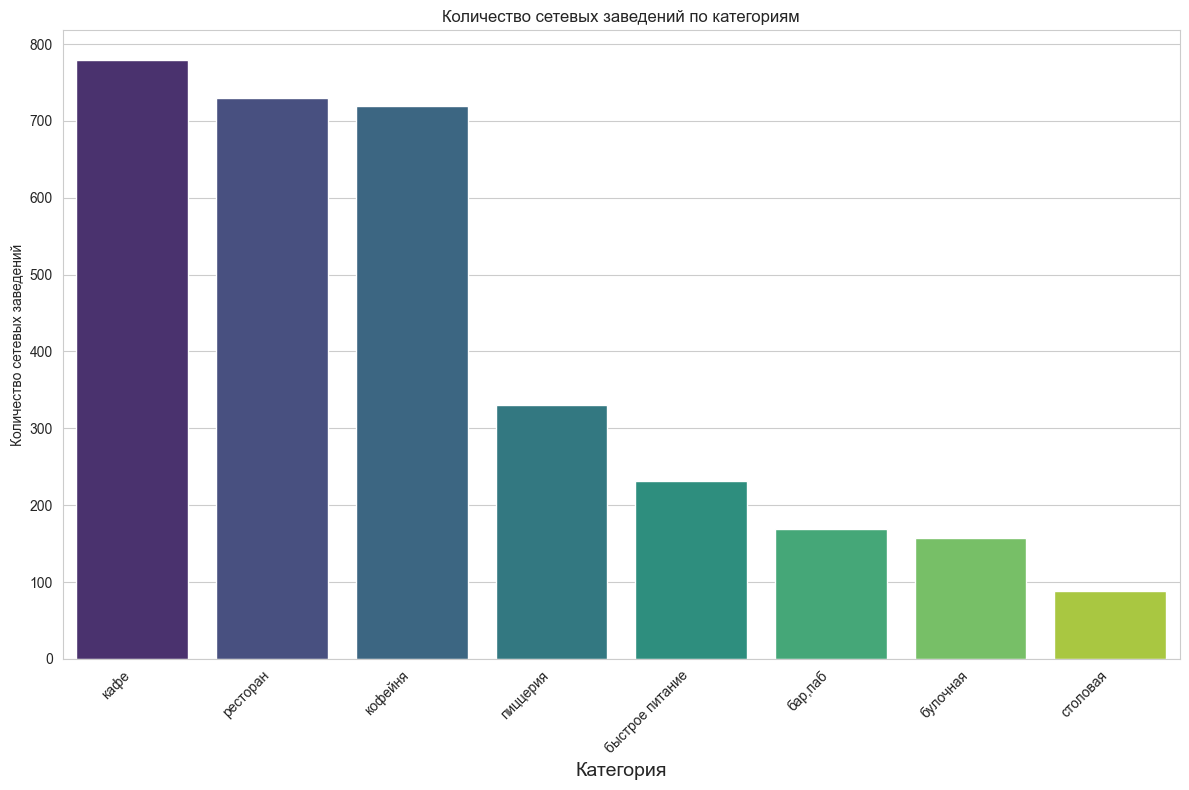

In [26]:
chain_counts = df['chain'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(chain_counts, labels=['Несетевые', 'Сетевые'], autopct='%1.1f%%', colors=['lightcoral', 'skyblue'], startangle=140)
plt.title('Доля сетевых и несетевых заведений')
plt.axis('equal')

category_counts = df.groupby('category')['chain'].value_counts().unstack()
category_counts['total'] = category_counts.sum(axis=1)
category_counts = category_counts.sort_values(by=1, ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts[1], palette='viridis')
plt.title('Количество сетевых заведений по категориям')
plt.xlabel('Категория', fontsize=14)
plt.ylabel('Количество сетевых заведений')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Доля сетевых и несетевых соотносится как 38,1% к 61,9%.
Среди сетевых чаще всего представлены всё те же три самые многочисленные категории: кафе, ресторан и кофейня. Также реже всего сетевыми бывают булочные и столовые.

###  Топ-15 популярных сетей в Москве

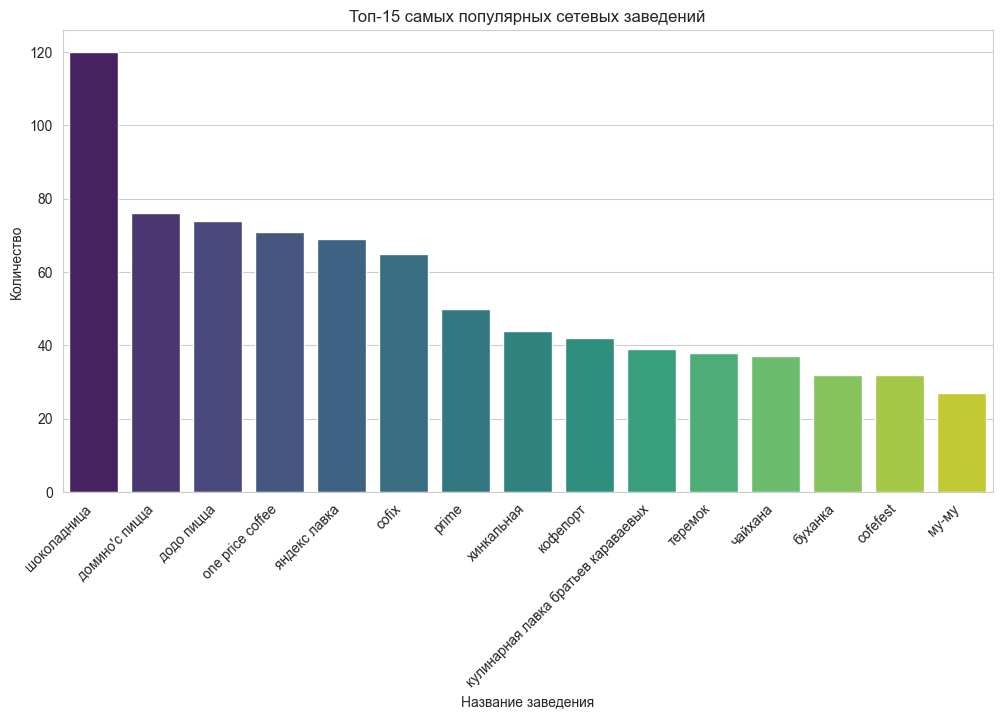

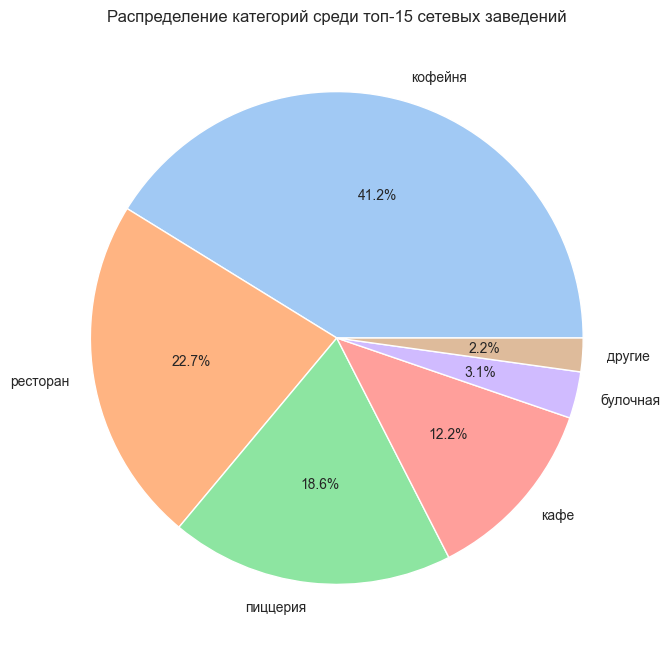

шоколадница                            120
домино'с пицца                          76
додо пицца                              74
one price coffee                        71
яндекс лавка                            69
cofix                                   65
prime                                   50
хинкальная                              44
кофепорт                                42
кулинарная лавка братьев караваевых     39
теремок                                 38
чайхана                                 37
буханка                                 32
cofefest                                32
му-му                                   27
Name: name, dtype: int64

In [27]:
top15 = df.query('chain == 1')['name'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top15.index, y=top15.values, palette='viridis')
plt.title('Топ-15 самых популярных сетевых заведений')
plt.xlabel('Название заведения')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')

category_counts = df.query('name in @top15.index')['category'].value_counts()
threshold = 25  
new_category_counts = {}
other_count = 0 
for category, count in category_counts.items():
    if count < threshold:
        other_count += count
    else:
        new_category_counts[category] = count
if other_count > 0:
    new_category_counts['другие'] = other_count
category_counts = pd.Series(new_category_counts).sort_values(ascending=False)
plt.figure(figsize=(8, 8))
category_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Распределение категорий среди топ-15 сетевых заведений')
plt.ylabel('')
plt.show()

top15

Составив список топ15 из наиболее часто встречающихся в датасете сетевых заведений, видим, что это в основном кофейни, кафе и пиццерии. Пайчарт показывает, что доля ресторанов составляет 22,8%, но, учитывая, что в данном датасете и Теремок классифицирован как ресторан, думаю, что доля ресторанов в традиционном понимании всё же будет существенно поменьше. Вызывает также вопросы присутстствие в этом списке даркстора Яндекс Лавка.

### Административные районы Москвы

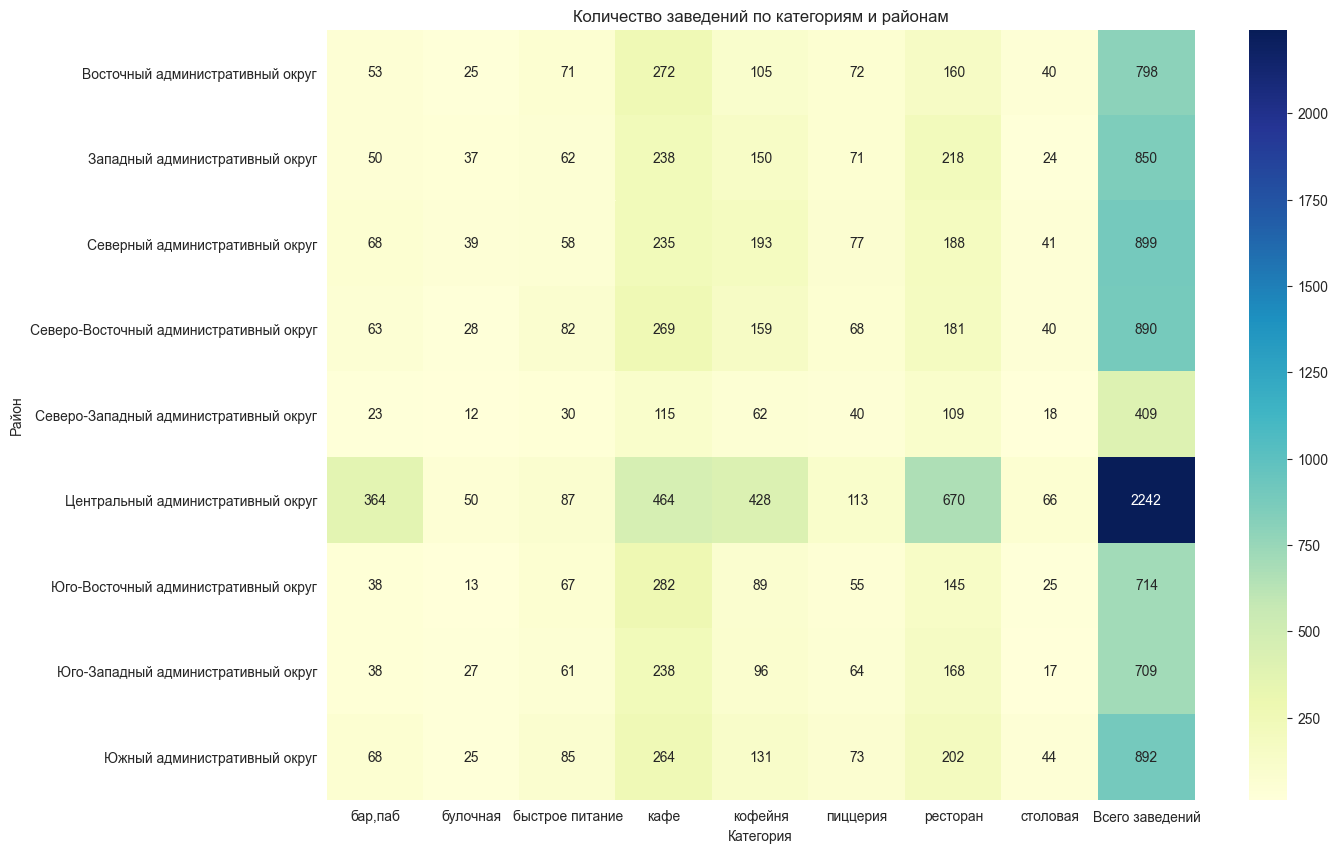

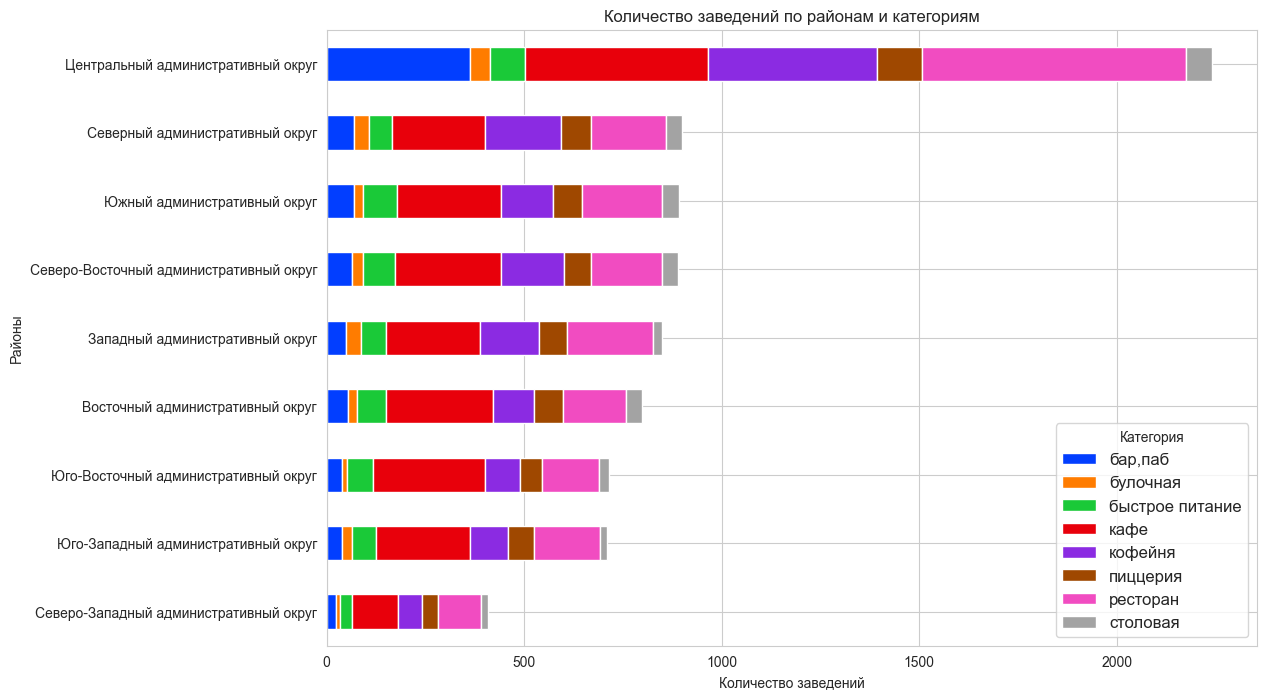

In [28]:
district_table = df.pivot_table(index='district', columns='category', aggfunc='size', fill_value=0)
district_table['Всего заведений'] = district_table.sum(axis=1)
plt.figure(figsize=(14, 10))
sns.heatmap(district_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Количество заведений по категориям и районам')
plt.xlabel('Категория')
plt.ylabel('Район')

counts_dist = df.groupby(['district', 'category']).size().unstack()
counts_dist = counts_dist.reindex(sorted(counts_dist.columns), axis=1)
counts_dist['total'] = counts_dist.sum(axis=1)  
counts_dist = counts_dist.sort_values(by='total', ascending=True).drop('total', axis=1)
fig, ax = plt.subplots(figsize=(12, 8))
counts_dist.plot(kind='barh', stacked=True, edgecolor='white', ax=ax)
ax.set_xlabel('Количество заведений')
ax.set_ylabel('Районы')
ax.set_title('Количество заведений по районам и категориям')
ax.legend(title='Категория', fontsize='large')
plt.show()

В целом количество заведений довольно равномерно распределено по всем районам, за исключением ЦАО, где видно контрастно высокое количество ресторанов, а также повышенную концентрацию баров, кафе и кофеен. Меньше всего заведений присутствует в Северно-Западном округе и это значение в 1,5-2 раза ниже характерного для всех других районов. Можно связать это с относительно невысоким количеством жителей СЗАО и тем, что 46% площади занято лесопарковыми массивами и заповедными зонами.

### Распределение средних рейтингов

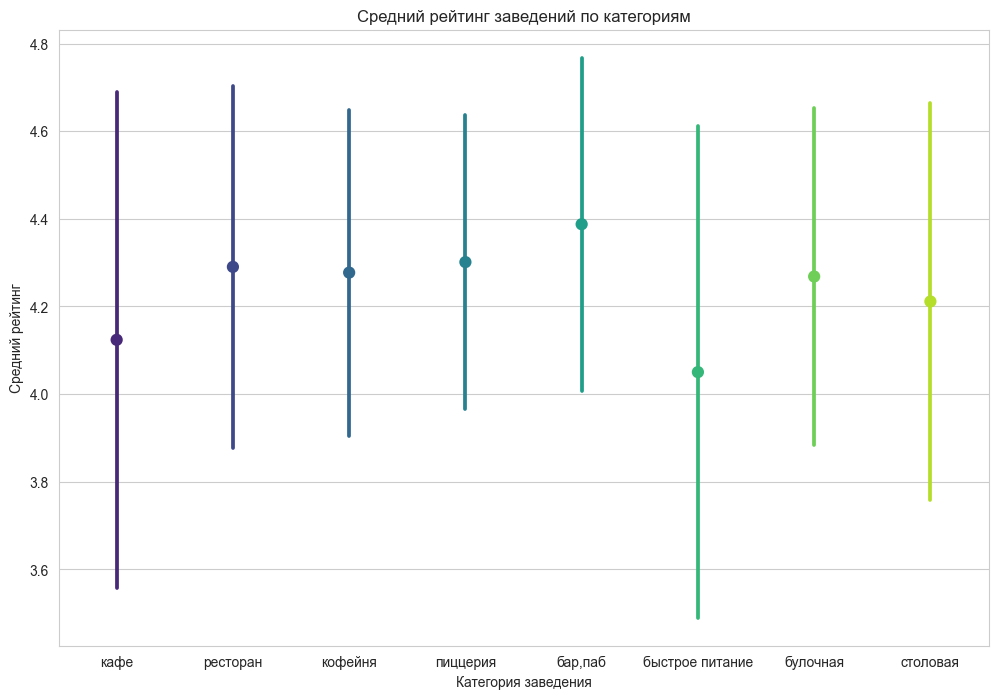

In [29]:
plt.figure(figsize=(12, 8))
sns.pointplot(data=df, x='category', y='rating', ci='sd', palette='viridis')
plt.title('Средний рейтинг заведений по категориям')
plt.xlabel('Категория заведения')
plt.ylabel('Средний рейтинг')
plt.show()

Самый низкий уровень среднего балла 4.0-4.1, а также самый большой разброс значений рейтинга от 3 до 4.7 баллов у кафе и быстрого питания. Все остальные категории имеют приблизительно схожее распределение и средний балл в районе 4.3. Примечательно, что самые высокие оценки чаще получают бары и пабы.

In [30]:
rating_df = df.groupby('district', as_index=False)['rating'].agg('median')
with open('D:\\ds\\admin_level_geomap.geojson', encoding='utf-8') as f:
    state_geo = json.load(f)
moscow_lat, moscow_lng = 55.751244, 37.618423

In [31]:
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')
Choropleth(
    geo_data=state_geo,
    data=rating_df,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Медианный рейтинг заведений по районам',
).add_to(m)
#m

![](catering_maps/01.png)

Самые высокие оценки - в центре, ниже всего на северо и юго-востоке.

### Расположение заведений на карте

In [32]:
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)

In [33]:
m_c = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles="Cartodb Positron")
marker_cluster = MarkerCluster().add_to(m_c)
df.apply(create_clusters, axis=1)
#m_c

0       None
1       None
2       None
3       None
4       None
        ... 
8401    None
8402    None
8403    None
8404    None
8405    None
Length: 8403, dtype: object

![](catering_maps/02.png)

В целом количество заведений уменьшается по мере удаления от центра к окраинам, но некоторые жилые массивы ближе к окраинам обладают высоким показателем концентрации. 

### Топ-15 улиц по количеству заведений

In [34]:
top15_streets = df['street'].value_counts().head(15)
df_streets = df.query('street in @top15_streets.index')

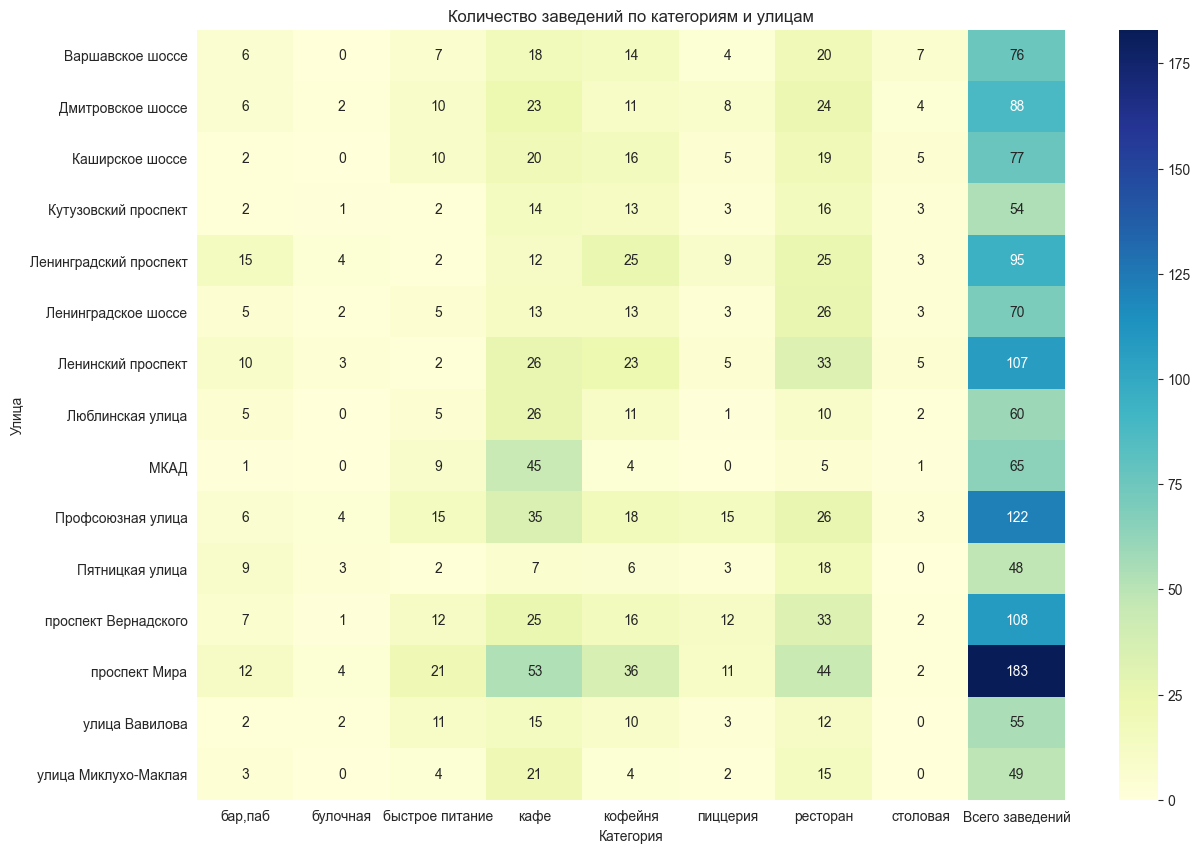

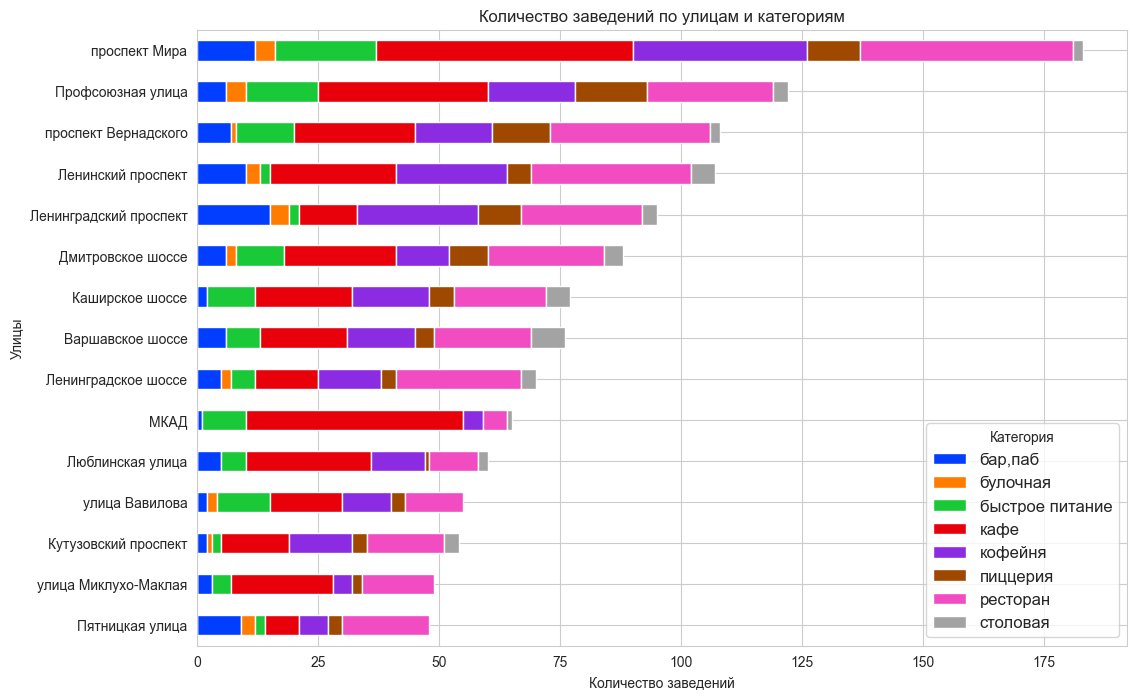

In [35]:
street_table = df_streets.pivot_table(index='street', columns='category', aggfunc='size', fill_value=0)
street_table['Всего заведений'] = street_table.sum(axis=1)
plt.figure(figsize=(14, 10))
sns.heatmap(street_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Количество заведений по категориям и улицам')
plt.xlabel('Категория')
plt.ylabel('Улица')

counts_st = df_streets.groupby(['street', 'category']).size().unstack()
counts_st = counts_st.reindex(sorted(counts_st.columns), axis=1)
counts_st['total'] = counts_st.sum(axis=1)
counts_st = counts_st.sort_values(by='total', ascending=True).drop('total', axis=1)
fig, ax = plt.subplots(figsize=(12, 8))
counts_st.plot(kind='barh', stacked=True, edgecolor='white', ax=ax)
ax.set_xlabel('Количество заведений')
ax.set_ylabel('Улицы')
ax.set_title('Количество заведений по улицам и категориям')
ax.legend(title='Категория', fontsize='large')
plt.show()

Также наблюдаем довольно равномерное распределение среди 15 улиц с наибольшей концентрацией, в котором выраженным лидером является проспект Мира. Логично, что улицы с наибольшим показателем преимущественно находятся в ЦАО. Посмотрю на улицы с количеством заведений, равным 1.

In [36]:
df['street'].value_counts().sort_values().head(15)

Савёловская линия                       1
улица Юннатов                           1
улица Пивченкова                        1
улица Литвина-Седого                    1
улица Чистова                           1
Тюменский проезд                        1
Замоскворецкая линия                    1
Ставропольская улица                    1
улица Неверовского                      1
Самарская улица                         1
Солянский тупик                         1
Смоленская-Сенная площадь               1
2-й Вышеславцев переулок                1
природно-исторический парк Измайлово    1
Выползов переулок                       1
Name: street, dtype: int64

Ничего особенного про эти улицы сказать нельзя. Это может быть как улица посреди научного, больничного или промышленного комплекса, так и небольшой переулок или улица, рассчитанная на движение автомобилей.

### Значения средних чеков

In [37]:
bill_df = df.groupby('district', as_index=False)['middle_avg_bill'].agg('median')
m_b = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')
Choropleth(
    geo_data=state_geo,
    data=bill_df,
    columns=['district', 'middle_avg_bill'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity=0.8,
    legend_name='Медианный чек по районам',
).add_to(m_b)
#m_b

![](catering_maps/03.png)

Самый высокий средний чек опять же в центре, следом Западный округ с элитной недвижимостью и юго-запад немного выделяется на фоне всех оставшихся районов, где медианный чек примерно одинаков в диапазоне 350-408 руб.

### Круглосуточные заведения

Посмотрим, как распределены на карте круглосуточные заведения.

In [38]:
round_df = df.query('is_24_7 == True')
m_r = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles="Cartodb Positron")
marker_cluster = MarkerCluster().add_to(m_r)
round_df.apply(create_clusters, axis=1)
#m_r

10      None
17      None
19      None
24      None
49      None
        ... 
8394    None
8399    None
8403    None
8404    None
8405    None
Length: 730, dtype: object

![](catering_maps/04.png)

По мере удаления от центра их всё меньше. Для Реутова не свойственно особенно. Посмотрю какие категории чаще бывают круглосуточными.

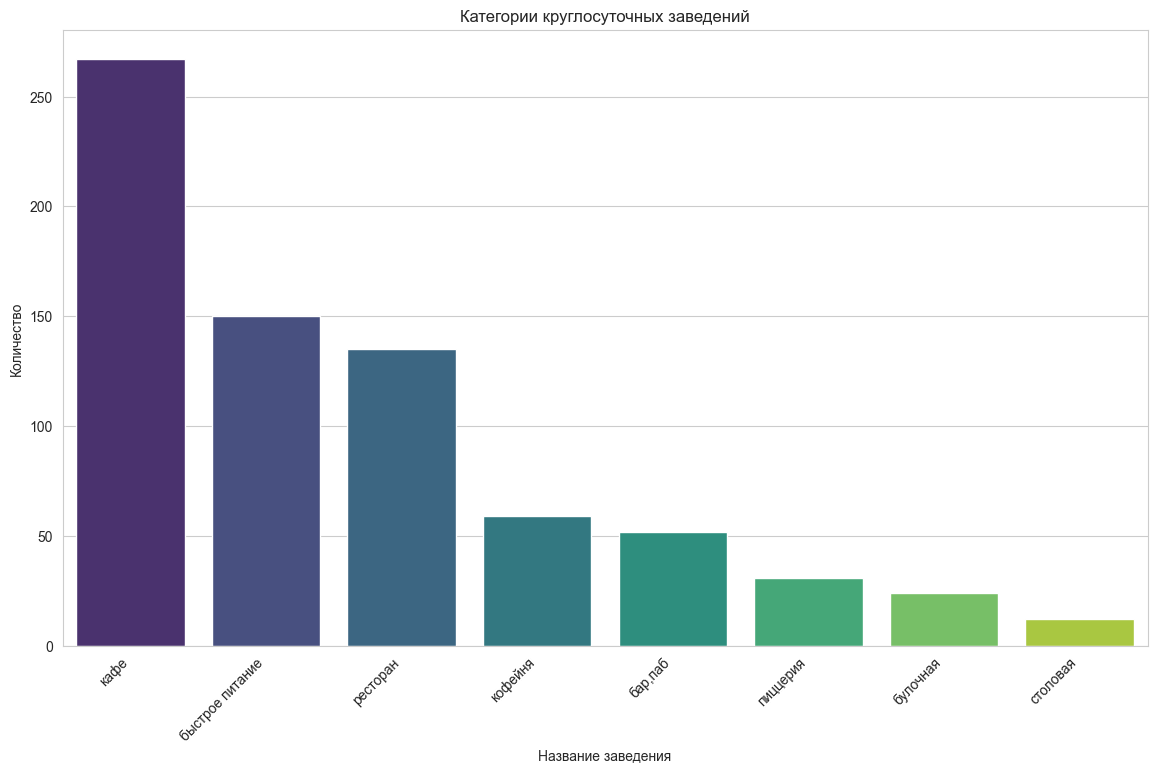

In [39]:
round_counts = round_df['category'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=round_counts.index, y=round_counts.values, palette='viridis')
plt.title('Категории круглосуточных заведений')
plt.xlabel('Название заведения')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.show()

На этот раз кофейни вышли из топа, а их местно заняли заведения быстрого питания. Круглосуточную столовую удастся найти совсем редко.

### Заведения с низким рейтингом

In [40]:
bad_rating_df = df.query('rating < 3.5')
m_br = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles="Cartodb Positron")
marker_cluster = MarkerCluster().add_to(m_br)
bad_rating_df.apply(create_clusters, axis=1)
#m_br

47      None
49      None
53      None
56      None
132     None
        ... 
8377    None
8382    None
8391    None
8392    None
8395    None
Length: 434, dtype: object

![](catering_maps/05.png)

Где находятся заведения с плохим рейтингом? Очевидно, не в центре. В остальных районах везде найдётся несколько. Среди каких же категорий наивысшая доля плохого рейтинга?

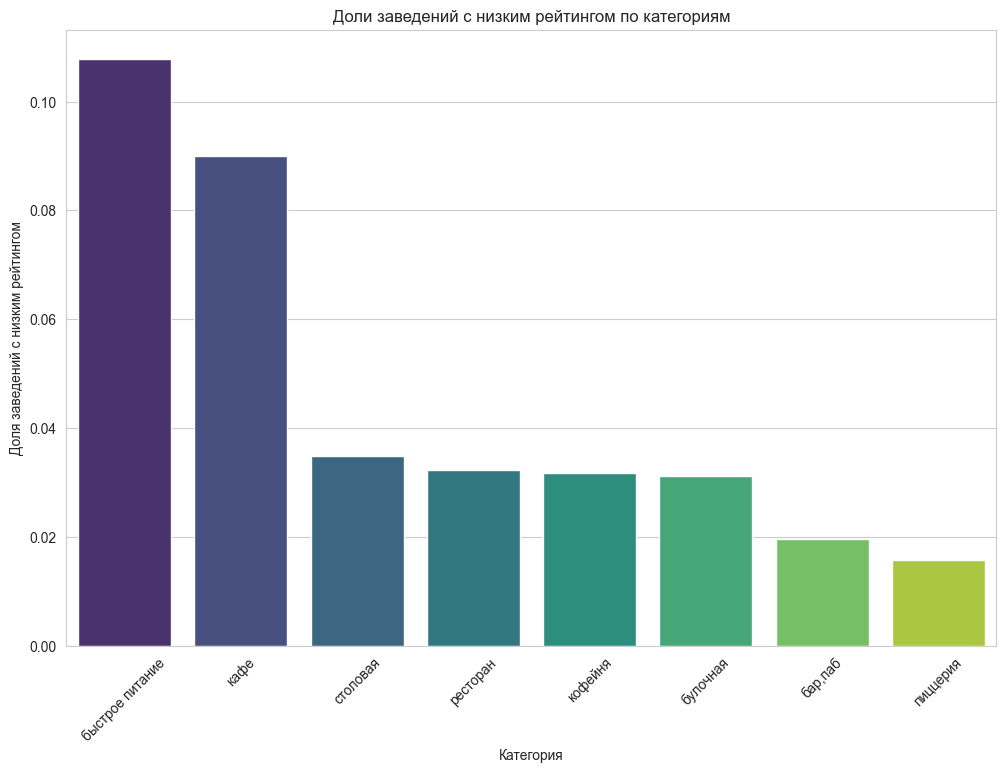

In [41]:
total_counts = df['category'].value_counts()
bad_counts = bad_rating_df['category'].value_counts()
ratios = bad_counts / total_counts
ratios = ratios.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=ratios.index, y=ratios.values, palette='viridis')
plt.title('Доли заведений с низким рейтингом по категориям')
plt.xlabel('Категория')
plt.ylabel('Доля заведений с низким рейтингом')
plt.xticks(rotation=45)
plt.show()

Лидер по доле заведений с низким рейтингом - быстрое питание, а у пиццерий и баров такая доля будет наименьшей. Посмотрим как распределены низкие оценки по разным категориям.

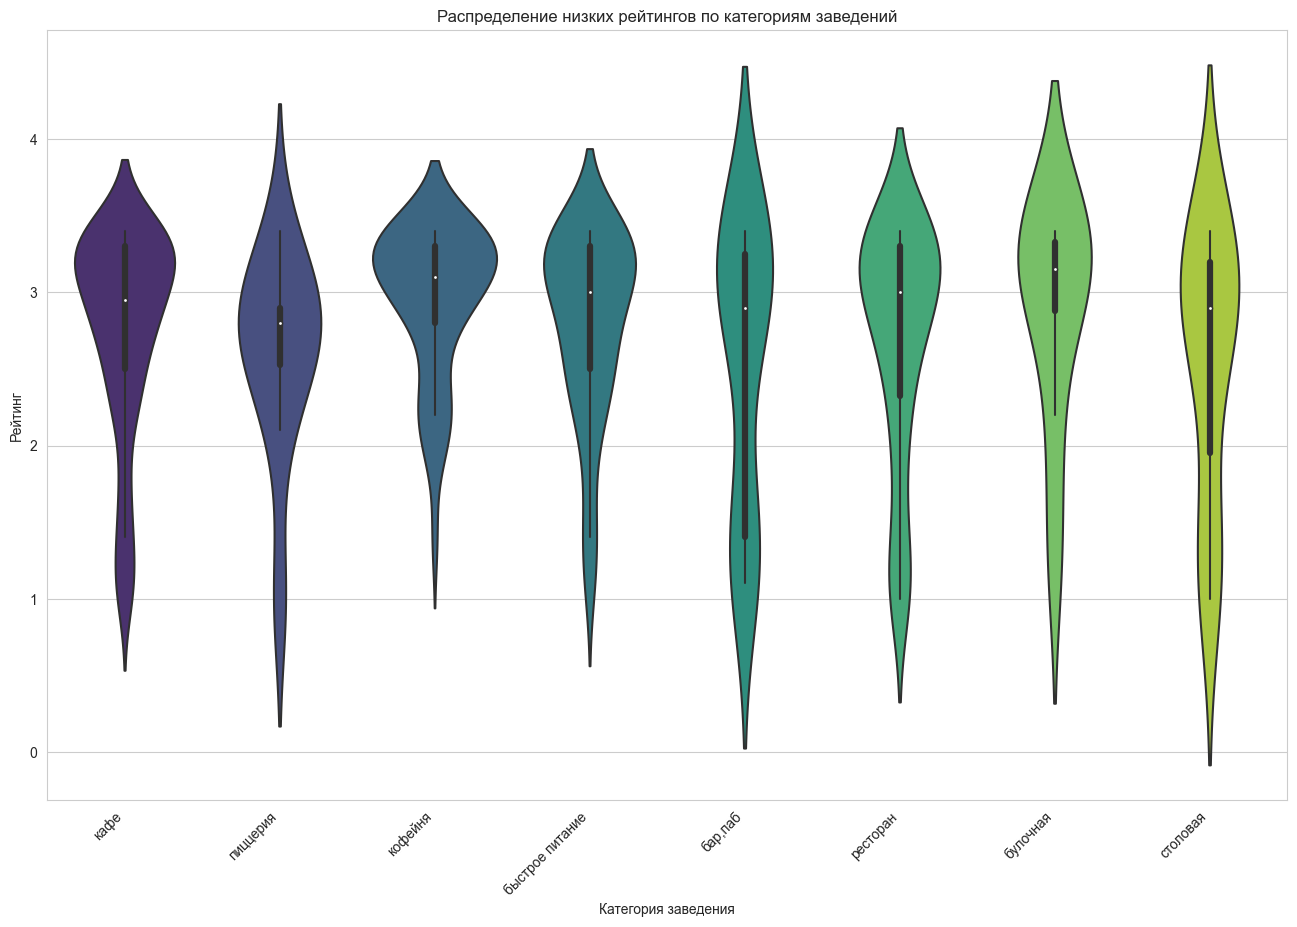

In [42]:
plt.figure(figsize=(16, 10))
sns.violinplot(x='category', y='rating', data=bad_rating_df, palette='viridis')
plt.title('Распределение низких рейтингов по категориям заведений')
plt.xlabel('Категория заведения')
plt.ylabel('Рейтинг')
plt.xticks(rotation=45, ha='right');

Наибольшим спектром низких оценок обладают бары и столовые. Видимо, только в этих заведениях могут оскорбить до глубины души. Причём у баров прослеживается наибольшая концентрация оценок в районе 1 и 3 баллов. Оценки кафе и кофеен довольно плотно сосредоточены в районе 3-3,5 баллов. Посмотрим на матрицу корреляций.

### Сравнение корреляций

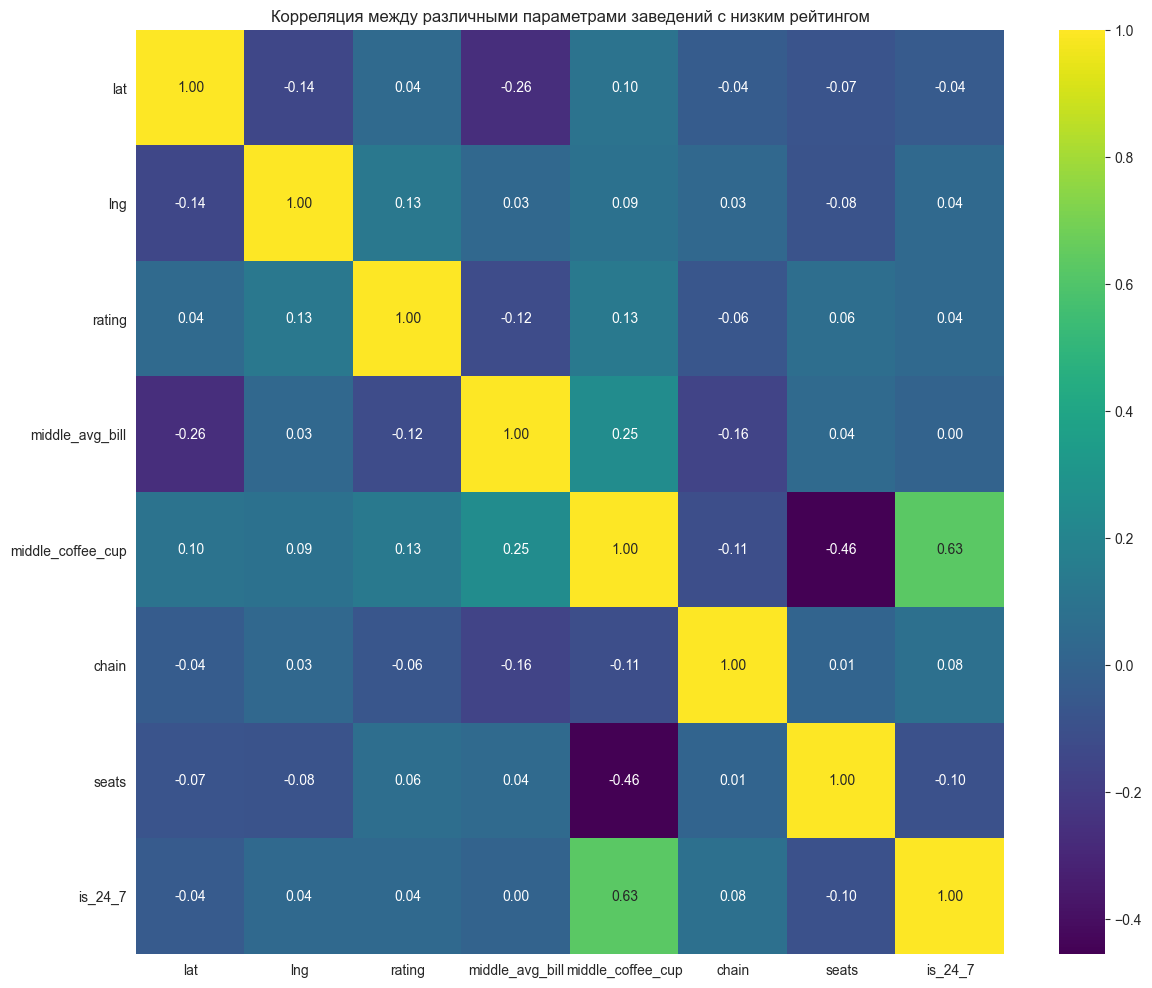

In [43]:
plt.figure(figsize=(14, 12))
sns.heatmap(bad_rating_df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Корреляция между различными параметрами заведений с низким рейтингом')
plt.show()

Собственно, сам низкий рейтинг ни с чем явно не коррелирует, везде показатель около нуля. Зато видим, что чем больше посадочных мест в заведении с низким рейтингом, тем дешевле кружка кофе, а также, что кофе дороже в круглосуточных заведениях. Для интереса составлю матрицу по всему датасету и по срезу заведений с высоким рейтингом.

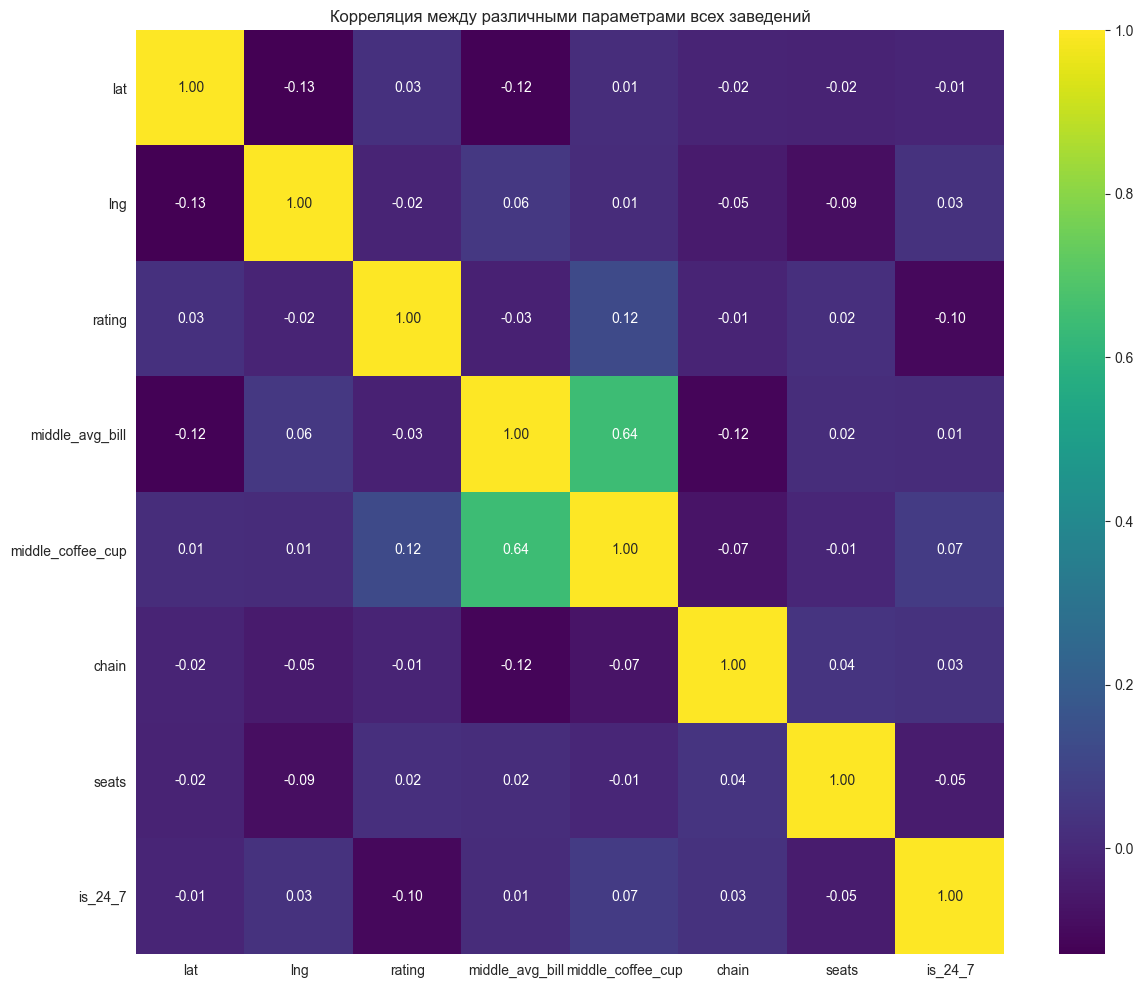

In [44]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Корреляция между различными параметрами всех заведений')
plt.show()

По всему датасету ничего интересного. Ничто не связано ни с чем.

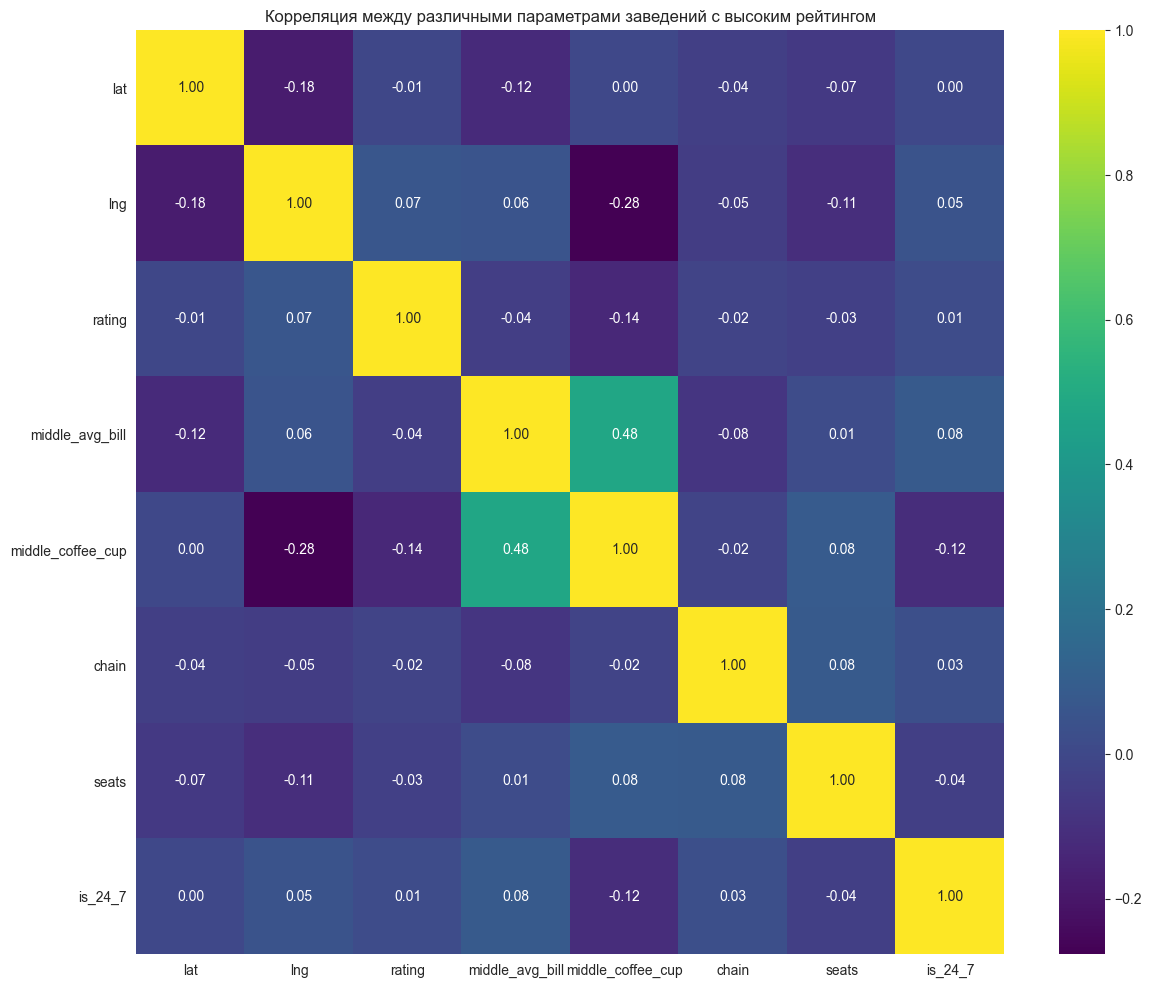

In [45]:
good_rating_df = df.query('rating > 4.5')
plt.figure(figsize=(14, 12))
sns.heatmap(good_rating_df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Корреляция между различными параметрами заведений с высоким рейтингом')
plt.show()

Такая же картина. От предоставленных параметров хороший рейтинг не зависит, интересных зависимостей не обнаружено.

## Детализация исследования: открытие кофейни

### Расположение

In [46]:
coffee_df = df.query('category == "кофейня"')
coffee_df['name'].count()

1413

Всего в датасете представлено 1413 кофеен. Посмотрим как они распределены по районам города.

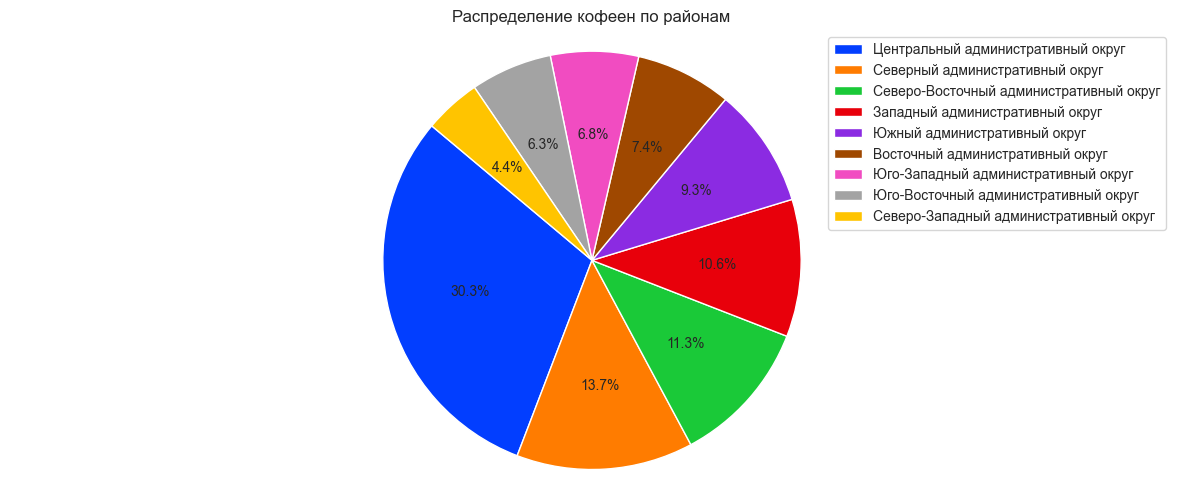

In [47]:
coffee_district_counts = coffee_df['district'].value_counts()

plt.figure(figsize=(15, 6))
patches, texts, autotexts = plt.pie(coffee_district_counts, autopct='%1.1f%%', startangle=140)
plt.title('Распределение кофеен по районам')
plt.axis('equal')
plt.legend(patches, coffee_district_counts.index, loc='best')
plt.show()

m_cc = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')
Choropleth(
    geo_data=state_geo,
    data=coffee_district_counts,
    columns=['district', 'name'],
    key_on='feature.properties.name',
    fill_color='YlOrBr',
    fill_opacity=0.8,
    legend_name='Количество кофеен по районам',
).add_to(m_cc)
#m_cc

![](catering_maps/06.png)

Большая часть находится в ЦАО и САО. Обычно предложение концентрируется там, где максимален и спрос. Но посмотрим ещё и на другие показатели.

### Часы работы

Посмотрим какие режимы работы кофеен встречаются в предоставленной выборке.

In [48]:
print(coffee_df['hours'].value_counts())

ежедневно, 10:00–22:00                  140
ежедневно, 08:00–22:00                   60
ежедневно, круглосуточно                 59
ежедневно, 09:00–22:00                   57
пн-пт 08:00–19:00                        46
                                       ... 
пн-чт 07:30–20:00; пт 07:30–19:00         1
ежедневно, 11:00–21:45                    1
вт,чт 10:00–18:00                         1
пн-сб 09:00–21:00; вс 09:00–20:00         1
пн-пт 08:00–19:00; сб,вс 09:00–18:00      1
Name: hours, Length: 362, dtype: int64


В совокупности больше тех, кто открыт с 8.00, рассчитывая напоить кофе тех, кто спешит утром на работу. Довольно большая доля и круглосуточных, посмотрим, где они расположены.

In [49]:
round_coffee_df = coffee_df.query('is_24_7 == True')
m_rcf = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles="Cartodb Positron")
marker_cluster = MarkerCluster().add_to(m_rcf)
round_coffee_df.apply(create_clusters, axis=1)
#m_rcf

200     None
971     None
1047    None
1214    None
1291    None
1468    None
1790    None
1825    None
1883    None
2030    None
2073    None
2245    None
2334    None
2353    None
2516    None
2636    None
3070    None
3081    None
3197    None
3218    None
3358    None
3366    None
3509    None
3511    None
3685    None
3688    None
3831    None
3987    None
4008    None
4038    None
4088    None
4112    None
4263    None
4292    None
4307    None
4320    None
4419    None
4502    None
4653    None
4734    None
4791    None
4916    None
5056    None
5131    None
5256    None
5304    None
5339    None
5383    None
5443    None
5891    None
6032    None
6045    None
6125    None
6558    None
6592    None
6890    None
7528    None
7668    None
7923    None
dtype: object

![](catering_maps/07.png)

Почти все они, конечно, в центре, там где never sleeps.

### Рейтинги

Посмотрим на гистограмму рейтингов у кофеен.

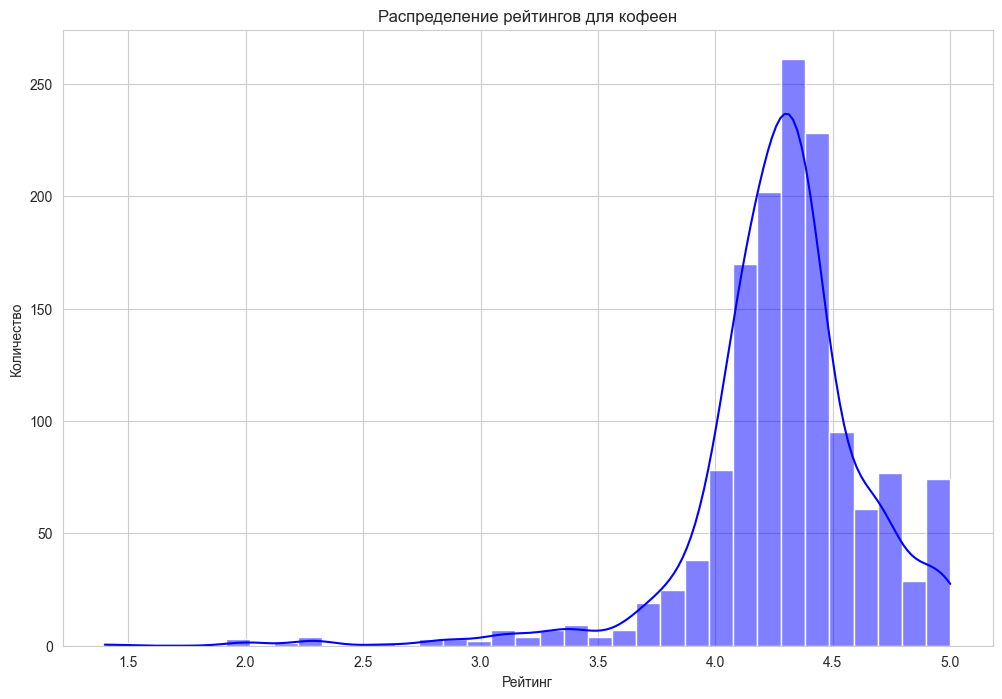

In [50]:
plt.figure(figsize=(12, 8))
sns.histplot(coffee_df['rating'], bins=35, kde=True, color='blue')
plt.title('Распределение рейтингов для кофеен')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()

Большая часть оценок расположена в диапазоне 4,3-4,5 баллов. Плохие оценки ставят редко, а пятёрки довольно часто. Вероятно, получить хорошую оценку от клиента не так уж и сложно. Возможно, достаточно просто хорошего кофе и минимального сервиса. Где же раздают хорошие оценки, посчитаю среднее арифмитическое.

In [51]:
coffee_rating_df = coffee_df.groupby('district', as_index=False)['rating'].agg('mean')
m_cr = Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')
Choropleth(
    geo_data=state_geo,
    data=coffee_rating_df,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Средний рейтинг кофеен по районам',
).add_to(m_cr)
display(coffee_rating_df)
#m_cr

,district,rating
0,Восточный административный округ,4.282857
1,Западный административный округ,4.195333
2,Северный административный округ,4.291710
3,Северо-Восточный административный округ,4.216981
4,Северо-Западный административный округ,4.325806
5,Центральный административный округ,4.336449
6,Юго-Восточный административный округ,4.225843
7,Юго-Западный административный округ,4.283333
8,Южный административный округ,4.232824


![](catering_maps/08.png)

Раздают в центре и на севере и северо-западе. Да и на востоке и на юге неплохо. А на Рублёвке почему-то не дают высоких оценок.

### Средний чек

Посчитаю на что можно рассчитывать в среднем.

In [52]:
print(f'Cредний чек по кофейням: {coffee_df["middle_avg_bill"].median()} руб.')
print(f'Cредняя стоимость кружки кофе: {coffee_df["middle_coffee_cup"].median()} руб.')

Cредний чек по кофейням: 190.0 руб.
Cредняя стоимость кружки кофе: 160.0 руб.


Построю картограммы по обеим этим метрикам.

In [53]:
bill_coffee_df = coffee_df.groupby('district', as_index=False)['middle_avg_bill'].agg('median')
m_bc = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')
Choropleth(
    geo_data=state_geo,
    data=bill_coffee_df,
    columns=['district', 'middle_avg_bill'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity=0.8,
    legend_name='Медианный чек кофеен по районам',
).add_to(m_bc)

cup_coffee_df = coffee_df.groupby('district', as_index=False)['middle_coffee_cup'].agg('median')
m_сcu = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10, tiles='Cartodb Positron')
Choropleth(
    geo_data=state_geo,
    data=cup_coffee_df,
    columns=['district', 'middle_coffee_cup'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity=0.8,
    legend_name='Медианная стоимость кружки кофе по районам',
).add_to(m_сcu)

#display(m_bc)
#display(m_сcu)

![](catering_maps/09.png)

![](catering_maps/10.png)

Самые высокие чеки в центре на западе и юго-западе. Самые низкие на востоке и юго-востоке.

### Рекомендации по открытию.

Подытоживая вышесказанное, можно выделить следующие рекомендации:
1. Расположение.
- ЦАО: в этом районе максимальны все показатели. Высокая конкуренция, высокая стоимость аренды, но и высокие средние чеки и высокий спрос.
- ЮЗАО: конкуренция ниже среднего, при этом высокие показатели среднего чека и стоимости кружки, кофейни в этом районе получают умеренно хорошие оценки.
- ЗАО: умеренная конкуренция, высокий средний чек и стоимость кружки, однако придётся постараться понравиться потребителю.
- САО: конкуренция чуть выше среднего, чеки на среднем уровне, средне-хорошие оценки. Среднячковый вариант.
- СЗАО: невысокая конкуренция и отличные оценки от потребителей, чек на среднем уровне.
- ВАО и ЮВАО: невысокая конкуренция и невысокий средний чек, оценки чуть выше среднего.

Стоит учитывать, что в районах с невысокой конкуренцией СЗАО, ВАО и ЮВАО и уровень спроса может быть ниже.

2. Часы работы.
- кофе утренний напиток и предпочитетельнее открывать кофейню с прицелом на ранний завтрак, как и работает большинство из представленных заведений.
- в случае размещения в ЦАО возможен режим работы 24x7 в случае высокой круглосуточной проходимости близлежащей к заведению зоны.
- в случае режима работы с 8.00 возможно размещение в формате "на вынос" рядом с местами посадки людей на общественный транспорт.
- в случае размещения рядом с офисными центрами можно выбирать режим работы с 9.00 или 10.00, рассчитывая на посещение теми, кто уже добрался до рабочего места.

## Общий вывод

Целью данного исследования было:
   - изучение основных характеристик рынка заведений общественного питания города Москвы
   - формирование рекомендаций для открытия нового заведения<br><br>
   
В ходе предобработки данных были выявлены и частично устранены пропущенные значения характеристик среднего чека, а также предоставленная таблица была дополнена новыми столбцами для удобства дальнейшей обработки.<br><br>

**Характеристики рынка:**
- чаще всего среди заведений встречаются кафе, рестораны и кофейни
- количество посадочных мест во всех категориях (кроме булочных) достигает 1200-1300 мест, наиболее характерное количество мест - 50-100
- доля сетевых заведений составляет 38,1%
- самые популярные сети - кофейни, кафе и пиццерии
- наибольшая концентрация заведений в Центральном Административном округе, распределение заведений по всем остальным округам равномерное
- кафе и заведениям быстрого питания характерен наибольший разброс рейтинга и наиболее низкий средний балл
- улица с наибольшим количеством заведений - проспект Мира и другие улицы ЦАО, наименьшее количество заведений на улицах посреди нежилых комплексов и небольших переулках
- самые высокие средние чеки в ЦАО и ЗАО
- круглосуточные заведения расположены в основном в центре и их количество сокращается по мере удаления от центра
- корреляций между низким рейтингом и изучаемыми характеристиками не обнаружено